<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smjayyy","key":"8eb172e224d83c7b56b4a2ef349b7c0d"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
##link dataset in Kaggle.com
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

 99% 159M/161M [00:08<00:00, 24.6MB/s]
100% 161M/161M [00:08<00:00, 19.4MB/s]


In [4]:
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

In [5]:
dataset_dir = '/content/data'

In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

from keras.applications import ResNet50

In [7]:
IMAGE_SIZE_resnet50 = 224

In [8]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_SIZE_resnet50, IMAGE_SIZE_resnet50))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [9]:
X = []
Z = []

In [10]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 1146/1146 [00:05<00:00, 229.15it/s]


In [11]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

# Konversi ke array numpy
X = np.array(X)

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE_resnet50, IMAGE_SIZE_resnet50, 3))

# Membuat model Sequential
model_resnet50ver2 = Sequential()
model_resnet50ver2.add(resnet50)
model_resnet50ver2.add(GlobalAveragePooling2D())
model_resnet50ver2.add(Dense(4, activation='softmax'))

# Membekukan layer-layer ResNet50 yang telah dilatih
for layer in resnet50.layers:
    layer.trainable = False

# Mengompilasi model dengan optimizer Adam dan loss function categorical crossentropy
model_resnet50ver2.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan summary dari model
model_resnet50ver2.summary()

# Melatih model dengan data latih dan validasi
history_resnet50ver2 = model_resnet50ver2.fit(X_train, Y_train, epochs=70, validation_data=(X_test, Y_test))

94765736/94765736 [==============================] - 5s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/70
105/105 [==============================] - 22s 141ms/step - loss: 0.3694 - accuracy: 0.8558 - val_loss: 0.2145 - val_accuracy: 0.9177
Epoch 2/70
105/105 [==============================] - 11s 108ms/s

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

# Menggunakan model_resnet50ver2 untuk membuat prediksi pada data uji
Y_pred = model_resnet50ver2.predict(X_test)
# Mengambil indeks kelas dengan probabilitas tertinggi sebagai prediksi
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Mengambil indeks kelas dengan probabilitas tertinggi sebagai label sebenarnya
Y_true = np.argmax(Y_test, axis=1)

# Membuat confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Membuat classification report
class_report = classification_report(Y_true, Y_pred_classes)

# Menampilkan classification report
print("\nClassification Report:")
print(class_report)

27/27 [==============================] - 3s 89ms/step
Confusion Matrix:
[[203   2  12   1]
 [  3 285   1   0]
 [ 13   3  88   0]
 [  0   0   0 227]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       218
           1       0.98      0.99      0.98       289
           2       0.87      0.85      0.86       104
           3       1.00      1.00      1.00       227

    accuracy                           0.96       838
   macro avg       0.94      0.94      0.94       838
weighted avg       0.96      0.96      0.96       838



In [15]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create train and validation generators
train_generator = datagen.flow(
    X_train,
    Y_train,
    batch_size=32,
    subset='training'
)

validation_generator = datagen.flow(
    X_train,
    Y_train,
    batch_size=32,
    subset='validation'
)

# Train the model
history_resnet50ver2 = model_resnet50ver2.fit(
    train_generator,
    epochs=70,
    validation_data=validation_generator
)

Epoch 1/70
84/84 [==============================] - 46s 552ms/step - loss: 1.3243 - accuracy: 0.3806 - val_loss: 1.2548 - val_accuracy: 0.4254
Epoch 2/70
84/84 [==============================] - 42s 498ms/step - loss: 1.2296 - accuracy: 0.4851 - val_loss: 1.2168 - val_accuracy: 0.3881
Epoch 3/70
84/84 [==============================] - 45s 531ms/step - loss: 1.1939 - accuracy: 0.5022 - val_loss: 1.1715 - val_accuracy: 0.5149
Epoch 4/70
84/84 [==============================] - 43s 518ms/step - loss: 1.1817 - accuracy: 0.5034 - val_loss: 1.1553 - val_accuracy: 0.5328
Epoch 5/70
84/84 [==============================] - 43s 511ms/step - loss: 1.1411 - accuracy: 0.5310 - val_loss: 1.1455 - val_accuracy: 0.4821
Epoch 6/70
84/84 [==============================] - 42s 495ms/step - loss: 1.1299 - accuracy: 0.5493 - val_loss: 1.1254 - val_accuracy: 0.6015
Epoch 7/70
84/84 [==============================] - 42s 498ms/step - loss: 1.1203 - accuracy: 0.5478 - val_loss: 1.1141 - val_accuracy: 0.5836

27/27 [==============================] - 2s 87ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.37      0.53       218
           1       0.80      0.90      0.85       289
           2       0.65      0.67      0.66       104
           3       0.70      0.98      0.82       227

    accuracy                           0.76       838
   macro avg       0.77      0.73      0.71       838
weighted avg       0.78      0.76      0.73       838



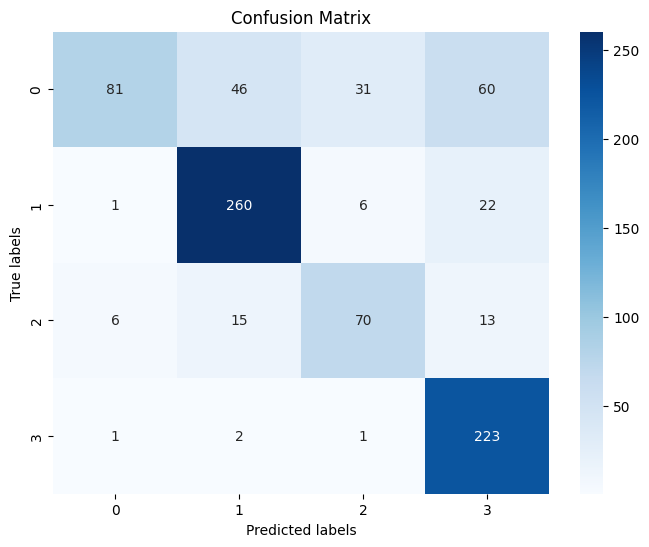

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi menggunakan model terlatih pada data uji
Y_pred = model_resnet50ver2.predict(X_test)

# Konversi prediksi dan label uji ke format yang sesuai
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Buat classification report
report = classification_report(Y_true, Y_pred_classes)
print("Classification Report:\n", report)

# Buat confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Tampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()